## 2 <center> SENTIMENT PREDICTION MODEL USING SAGEMAKER AUTOGLUON</center>

## Introduction

This NLP task utilizes preprocessed data to explore customers reviews/comments with the sole purpose of improving current services by addressing customers areas of concern and creating values to the business. To go gain insight about the problem, a historical dataset was provided for analysis and to build a machine learning model to predict sentiment`SCORE` using `Document-level`. In order to provide the best solutions, different algorithms were explored. In this project, we will use of the most powerful algorithm for NLP in order to predict sentiment scores. `AUTOGLUON` an algorithm that utilizes a state-of-the-arts pretrained BERT/transformer model together with Amazon SageMaker studio to achieve this feet. 

*Before I proceed, here are some of the assumptions I made based on the instructions:*

   1. I assume that the stakeholders are more interested in SCORE predictions. Hence, I will not normalize for probability scores or map the label to `Negative,Neutral and Positive` commonly used for sentiment analysis tasks.

   2. The model can be trained to make more accurate predications, however, I will limit my resources due to high cost of GPU🙂

### Import Libraries

In [1]:
# Libraries for data processing
import numpy as np
import pandas as pd
import os
import re
import string
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

# Sagemaker specific
import boto3
import sagemaker

# Access sagemaker resources
region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()
default_bucket = sagemaker_session.default_bucket()

### Install autogluon while uninstalling pytorch to avoid dependecies conflicts

In [2]:
%%sh
pip -q install autogluon
pip -q uninstall -y torch

### Clone dataset from github repository

Github repo was cloned into local repo for dataset access

In [3]:
train = pd.read_csv('NLP_task_train.csv.zip',index_col=0)
valid = pd.read_csv('NLP_task_validate.csv.zip',index_col=0)

In [4]:
# import to load zip files
from autogluon.core.utils.loaders import load_zip

In [5]:
# After EDA, these colums where identified as vital
df_train = train[['DOCUMENT_ID','SENTENCE','SCORE']]
df_valid = train[['DOCUMENT_ID','SENTENCE','SCORE']]

### Perform text cleaning.

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
# Apply the function to SENTENCE column as shown
df_train['SENTENCE'] = df_train['SENTENCE'].apply(lambda x:clean_text(x))
df_valid['SENTENCE'] = df_valid['SENTENCE'].apply(lambda x:clean_text(x))

#### Important Step Taken for stitching sentences to Document IID.
I chained all sentences with its corresponding unique DOCUMENTS_ID., reducing the total length of the trained dataset from `56644` to `39583`.
This ensures each document prediction given sentences. The `SENTENCE_START_POS` and `SENTENCE_END_POS` automatically have been taken care of in the code below. Once all the sentences are attached to their respective `DOCUMENT_ID`, the order is no longer of usef to the model. WHY? Because, the words will be tokenized, other factors such as word frequency, etc would be a deciding factor for prediction scores.

In [8]:
df_train = df_train.groupby(['DOCUMENT_ID','SCORE']).agg({'SENTENCE': ' '.join})
df_valid = df_valid.groupby(['DOCUMENT_ID','SCORE']).agg({'SENTENCE': ' '.join})

**Reset Index and changed DOCUMENT_ID data type from `Integer` to `String`.**
- I also prepared the test data by removing the `SCORE` column to enable model prediction as shown below

In [9]:
df_train = df_train.reset_index()
df_valid = df_valid.reset_index()
df_train['DOCUMENT_ID'] = df_valid['DOCUMENT_ID'].astype(str)
df_valid['DOCUMENT_ID'] = df_valid['DOCUMENT_ID'].astype(str)

In [10]:
# inspect the test and train data
df_test = df_valid[['DOCUMENT_ID','SENTENCE']]
df_test.head(2)

,DOCUMENT_ID,SENTENCE
0,34137006,good
1,34137007,best egg is very easy to deal with


In [11]:
df_train.head()

,DOCUMENT_ID,SCORE,SENTENCE
0,34137006,10.0,good
1,34137007,10.0,best egg is very easy to deal with
2,34137011,10.0,easy application process and quick response
3,34137012,10.0,ease of obtaining money to consolidate
4,34137013,10.0,the ease and courtesy in which the loan was ha...


## TRAIN MODEL - AutoGluon

'AutoGluon enables easy-to-use and easy-to-extend AutoML with a focus on automated stack ensembling, deep learning, and real-world applications spanning text, image, and tabular data'. Documentation can be found here: https://auto.gluon.ai/stable/index.html . As simple as it may sound yet powerful, the algorithm requires good knowledge of the archtecture to ensure correct input or data type and continous monitoring of logs.  

First step is to ensure we tell autogluon to infer features by passing in our training data to `FeatureMetadata`. 

In [12]:
from autogluon.tabular import FeatureMetadata
feature_metadata = FeatureMetadata.from_df(df_train)
print(feature_metadata)

('float', [])        : 1 | ['SCORE']
('object', [])       : 1 | ['DOCUMENT_ID']
('object', ['text']) : 1 | ['SENTENCE']


**By vitual inspection, we can see that the feature data types are correctly infered. Sometimes it's not always the case. When that happens, we can specify the schema ourself and pass it on by using the code below**

In [13]:
# Pretty good job with metadata. But i would like to infer DocumentID object
feature_metadata = FeatureMetadata({
    'SCORE':'float',
    'DOCUMENT_ID':'category',
    'SENTENCE':'text'})

In [14]:
print(feature_metadata)

('category', []) : 1 | ['DOCUMENT_ID']
('float', [])    : 1 | ['SCORE']
('text', [])     : 1 | ['SENTENCE']


### Set Hyperparameter

There are so many hyperparameters that can be specified such as `batch size, number of epoch,learning rate, strategy etc.` but we shall make use of auto mode and multimodal hyperparameters to automate tuning using `Baysian` search strategy.

In [15]:
# Building a multimodel  and configuring hyperparameter
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
hyperparameters = get_hyperparameter_config('multimodal')
hyperparameters

{'NN': {},
 'GBM': [{},
  {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
  'GBMLarge'],
 'CAT': {},
 'XGB': {},
 'AG_TEXT_NN': ['medium_quality_faster_train'],
 'AG_IMAGE_NN': {}}

From the output above, we can see different algorithms that autogluon will used to train our model. I decided to run all the algorithm to train and see which performs better. The AG_TEXT_NN is NLP algorithm that uses state-of-the-act BERT/transformer model architecture to train the text column. More information can be found here:https://nlp.gluon.ai/model_zoo/sentiment_analysis/index.html

In [16]:
# Import a tabular predictor
from autogluon.tabular import TabularPredictor

### Evaluation Metric

Preferably, `recall_micro` does a great job when it comes to multi-class classifications. In our case, there are more examples of one class than many other classes as can be seen on the EDA notebook. Micro-average will aggregate the contributions of all classes to compute the average metric which helps in addressing class imbalance problems most common in multi-class classification. 

Secondly, since our main is finding insights from users reviews/comments and improving their experience, It would be a strategic move to pay more attention to negative sentiments because the cost to business outcome is expensive whereby we lose customers which would lead to loss of revenue as well. Hence, a true positive rate(recall) would take a hard look at identifying those negative sentiments and fixing the problems to improve customers' experience while adding value to the company.

### Start Training

No path specified. Models will be saved in: "AutogluonModels/ag-20211224_165431/"
Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "AutogluonModels/ag-20211224_165431/"
AutoGluon Version:  0.3.1
Train Data Rows:    39583
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == float, but few unique label-values observed and label-values can be converted to int).
	First 10 (of 11) unique label values:  [10.0, 8.0, 7.0, 5.0, 9.0, 3.0, 1.0, 0.0, 6.0, 4.0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 11
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    15361.95 MB
	Train Data (Original)  Memory Usage: 7.1 MB (0.0% of available memor

[16:56:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	0.7736	 = Validation score   (recall_micro)
	8.73s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetMXNet ... Training model for up to 7095.13s of the 7093.34s of remaining time.
	0.7696	 = Validation score   (recall_micro)
	33.65s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 7061.26s of the 7059.47s of remaining time.
	0.77	 = Validation score   (recall_micro)
	21.65s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: TextPredictor ... Training model for up to 7039.1s of the 7037.32s of remaining time.


All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_165431/models/TextPredictor/task0/training.log


[Iter 58/2900, Epoch 0] valid accuracy=7.6960e-01, log_loss=8.2226e-01, recall_micro=7.6960e-01, time spent=6.195s, total time spent=1.28min. Find new best=True, Find new top-3=True
[Iter 116/2900, Epoch 0] valid accuracy=7.7360e-01, log_loss=7.4161e-01, recall_micro=7.7360e-01, time spent=6.197s, total time spent=2.52min. Find new best=True, Find new top-3=True
[Iter 174/2900, Epoch 0] valid accuracy=7.7640e-01, log_loss=7.6820e-01, recall_micro=7.7640e-01, time spent=5.965s, total time spent=3.74min. Find new best=True, Find new top-3=True
[Iter 232/2900, Epoch 0] valid accuracy=7.7960e-01, log_loss=7.2941e-01, recall_micro=7.7960e-01, time spent=6.456s, total time spent=4.93min. Find new best=True, Find new top-3=True
[Iter 290/2900, Epoch 0] valid accuracy=7.7480e-01, log_loss=7.3023e-01, recall_micro=7.7480e-01, time spent=6.071s, total time spent=6.04min. Find new best=False, Find new top-3=True
[Iter 348/2900, Epoch 1] valid accuracy=7.7800e-01, log_loss=7.1678e-01, recall_micro

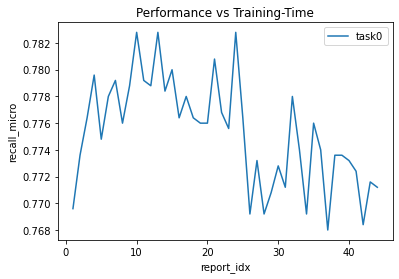

	0.7824	 = Validation score   (recall_micro)
	3022.71s	 = Training   runtime
	7.78s	 = Validation runtime
Fitting model: ImagePredictor ... Training model for up to 4003.69s of the 4001.9s of remaining time.
	No valid features to train ImagePredictor... Skipping this model.
Fitting model: WeightedEnsemble_L2 ... Training model for up to 719.04s of the 3990.02s of remaining time.
	0.786	 = Validation score   (recall_micro)
	1.25s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3214.62s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20211224_165431/")


In [17]:
label ='SCORE'
eval_metric = 'recall_micro'

predictor = TabularPredictor(label=label,eval_metric=eval_metric).fit(
    train_data = df_train,
    hyperparameters=hyperparameters,
    time_limit=2*3600)

### Analysis of Training Job
The model did quite a great job by identifying the key information, eg the number of labels (SCORE column) was correctly identified. TextNgramFeatureGenerator was generated and CountVectorizer fitted for text features (SENTENCE). CountVectorizer fit with vocabulary size = 2967 and so on. Overall the job took `2823.84s` to complete. This training job utilized 4CPu + 1 GPU, the kernel used is `python3(MXNet 1.8 Python 3.7 on GPU Optimized`. The Graph of performance vs training time is shown above. The model made it to 78% recall_micro before making its way down the cliff.

### Leaderboard for the best Performance Model
WeightedEnsemble_L2 leads with a validation score of `0.7852` followed by `TextPredictor`  with a score of `0.7816`. Surprisingly, NeuralNetMXNet came second to last😏. I wouldn't have guessed right. However, specifying different hyperparameters could be a game-changer. Batch size, learning rate, and more training could improve the results to achieve a better result.

In [18]:
predictor.leaderboard()

                 model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2     0.7860       8.063230  3076.662023                0.001719           1.247743            2       True          8
1        TextPredictor     0.7824       7.781736  3022.710102                7.781736        3022.710102            1       True          7
2           LightGBMXT     0.7780       0.261237    19.328793                0.261237          19.328793            1       True          2
3             LightGBM     0.7744       0.274268    21.399834                0.274268          21.399834            1       True          1
4              XGBoost     0.7736       0.087023     8.728034                0.087023           8.728034            1       True          4
5        LightGBMLarge     0.7700       0.176262    21.650284                0.176262          21.650284            1       True          6
6       NeuralNetMXN

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.7860,8.063230,3076.662023,0.001719,1.247743,2,True,8
1,TextPredictor,0.7824,7.781736,3022.710102,7.781736,3022.710102,1,True,7
2,LightGBMXT,0.7780,0.261237,19.328793,0.261237,19.328793,1,True,2
3,LightGBM,0.7744,0.274268,21.399834,0.274268,21.399834,1,True,1
4,XGBoost,0.7736,0.087023,8.728034,0.087023,8.728034,1,True,4
5,LightGBMLarge,0.7700,0.176262,21.650284,0.176262,21.650284,1,True,6
6,NeuralNetMXNet,0.7696,0.046210,33.652450,0.046210,33.652450,1,True,5
7,CatBoost,0.7696,0.192753,43.976145,0.192753,43.976145,1,True,3


## Model Prediction
Using the test data, let's predict the score label using sentence with their corresponding document ID

In [19]:
# predict and ensure the result is a pandas dataframe
y_pred = predictor.predict(df_test,as_pandas=True)
y_pred = y_pred.to_frame()

In [20]:
# Rename predicted column to differentiate from actual SCORE
predicted = y_pred.rename(columns={'SCORE': 'PREDICTED'})

In [21]:
# Concatenate using the index column. The column was preserved to ensure it matches correctly. 
pred_vs_actual = pd.concat([predicted, df_valid], axis=1)
pred_vs_actual = pred_vs_actual[['PREDICTED','SCORE','DOCUMENT_ID','SENTENCE']]

#Save file to CSV
pred_vs_actual.to_csv("predicted-actual.csv",index=False)

In [22]:
# Prediction
pred_vs_actual.head(10)

,PREDICTED,SCORE,DOCUMENT_ID,SENTENCE
0,10.0,10.0,34137006,good
1,10.0,10.0,34137007,best egg is very easy to deal with
2,10.0,10.0,34137011,easy application process and quick response
3,10.0,10.0,34137012,ease of obtaining money to consolidate
4,10.0,10.0,34137013,the ease and courtesy in which the loan was ha...
5,10.0,8.0,34137014,fast and easy service
6,10.0,10.0,34137019,very helpful and took only days to receive fu...
7,10.0,10.0,34137038,process is very straight forward and easy
8,10.0,10.0,34137039,it was quick and easy but then i had most eve...
9,10.0,7.0,34137041,fast and courteous


* The result above showed the predicted vs actual(SCORE). On `row 2` for example, the model predicted `10` as against actual which is `8`. 

### RESIDUAL PLOT

#### Residuals plot to visualize the distribution
A residual plot below shows the distribution and standard deviation away from the center.

In [23]:
residuals = (predicted.PREDICTED - df_valid.SCORE)

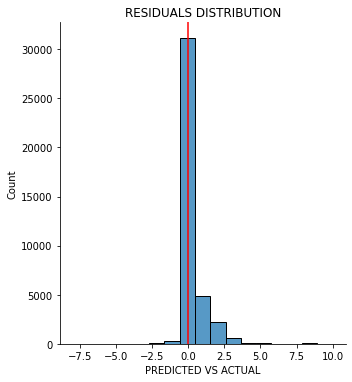

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.rcParams['figure.figsize'] = (10,8)
ax = sns.displot(residuals)
ax.set(title='RESIDUALS DISTRIBUTION')
plt.axvline(color='r')
ax.set(xlabel = 'PREDICTED VS ACTUAL')
plt.show()

#### As seen in the plot, the model still has room for improvement and this can be done by: 

1. Trying different ranges of hyperparameters values
2. Train longer while monitoring the performance to avoid overfitting.
3. Taking the best model and train alone while experimenting using steps 1 and 2.
4. Selecting a custom pretrained model as can be seen here: https://nlp.gluon.ai/model_zoo/sentiment_analysis/index.html

### Train with the pretrained Best Performance Model.
Let's train for additional 3hr using the best model from the previous job and see if there would be an improvement.

No path specified. Models will be saved in: "AutogluonModels/ag-20211224_175005/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "AutogluonModels/ag-20211224_175005/"
AutoGluon Version:  0.3.1
Train Data Rows:    39583
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == float, but few unique label-values observed and label-values can be converted to int).
	First 10 (of 11) unique label values:  [10.0, 8.0, 7.0, 5.0, 9.0, 3.0, 1.0, 0.0, 6.0, 4.0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 11
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11040.25 MB
	Train Data (Original)  Memory U

[18:14:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

	0.7744	 = Validation score   (recall_micro)
	69.32s	 = Training   runtime
	0.88s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L1 ... Training model for up to 5691.65s of the 9291.14s of remaining time.
	0.7695	 = Validation score   (recall_micro)
	340.74s	 = Training   runtime
	0.95s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 5349.13s of the 8948.62s of remaining time.
	0.7737	 = Validation score   (recall_micro)
	291.84s	 = Training   runtime
	8.62s	 = Validation runtime
Fitting model: TextPredictor_BAG_L1 ... Training model for up to 5040.59s of the 8640.08s of remaining time.


All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F1/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6939e-01, log_loss=8.3313e-01, recall_micro=7.6939e-01, time spent=9.899s, total time spent=1.22min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7419e-01, log_loss=7.5007e-01, recall_micro=7.7419e-01, time spent=10.065s, total time spent=2.48min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7419e-01, log_loss=7.2933e-01, recall_micro=7.7419e-01, time spent=10.424s, total time spent=3.73min. Find new best=True, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7318e-01, log_loss=7.9174e-01, recall_micro=7.7318e-01, time spent=9.910s, total time spent=4.90min. Find new best=False, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.7621e-01, log_loss=7.4830e-01, recall_micro=7.7621e-01, time spent=9.911s, total time spent=6.12min. Find new best=True, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.7520e-01, log_loss=7.1428e-01, recall_mic

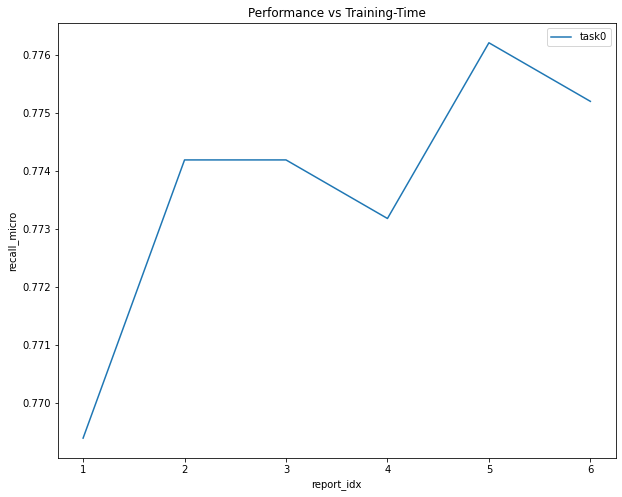

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F2/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6939e-01, log_loss=8.0757e-01, recall_micro=7.6939e-01, time spent=9.639s, total time spent=1.24min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7747e-01, log_loss=7.5642e-01, recall_micro=7.7747e-01, time spent=9.485s, total time spent=2.52min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7671e-01, log_loss=7.2702e-01, recall_micro=7.7671e-01, time spent=9.983s, total time spent=3.67min. Find new best=False, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7772e-01, log_loss=7.1285e-01, recall_micro=7.7772e-01, time spent=9.740s, total time spent=4.91min. Find new best=True, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.7469e-01, log_loss=7.2903e-01, recall_micro=7.7469e-01, time spent=9.698s, total time spent=6.02min. Find new best=False, Find new top-3=False
[Iter 336/2790, Epoch 1] valid accuracy=7.7848e-01, log_loss=7.1884e-01, recall_mic

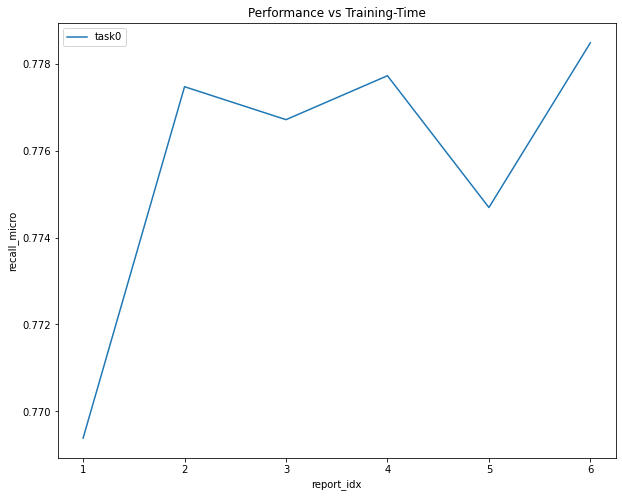

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F3/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6939e-01, log_loss=8.1182e-01, recall_micro=7.6939e-01, time spent=10.438s, total time spent=1.28min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7267e-01, log_loss=7.3104e-01, recall_micro=7.7267e-01, time spent=10.752s, total time spent=2.59min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7469e-01, log_loss=7.4300e-01, recall_micro=7.7469e-01, time spent=11.270s, total time spent=3.89min. Find new best=True, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7797e-01, log_loss=7.1784e-01, recall_micro=7.7797e-01, time spent=11.385s, total time spent=5.17min. Find new best=True, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.8202e-01, log_loss=7.0992e-01, recall_micro=7.8202e-01, time spent=11.339s, total time spent=6.47min. Find new best=True, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.7621e-01, log_loss=7.1426e-01, recall_m

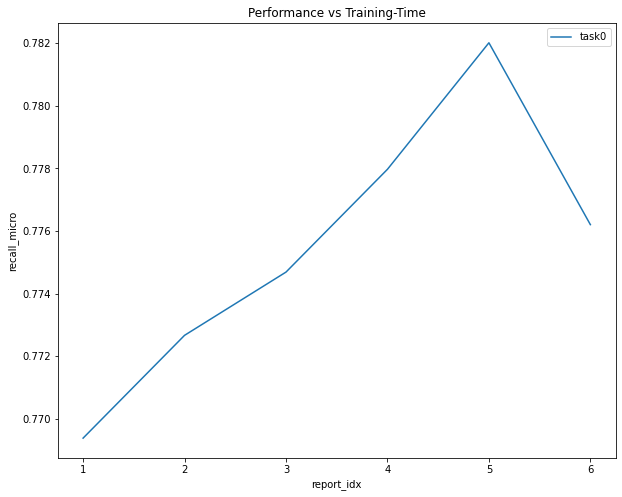

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F4/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6958e-01, log_loss=8.3558e-01, recall_micro=7.6958e-01, time spent=10.692s, total time spent=1.32min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7741e-01, log_loss=7.3689e-01, recall_micro=7.7741e-01, time spent=10.671s, total time spent=2.66min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7893e-01, log_loss=7.3141e-01, recall_micro=7.7893e-01, time spent=10.705s, total time spent=3.98min. Find new best=True, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.8322e-01, log_loss=7.1230e-01, recall_micro=7.8322e-01, time spent=10.750s, total time spent=5.26min. Find new best=True, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.8095e-01, log_loss=7.1600e-01, recall_micro=7.8095e-01, time spent=10.745s, total time spent=6.49min. Find new best=False, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.8120e-01, log_loss=7.0344e-01, recall_

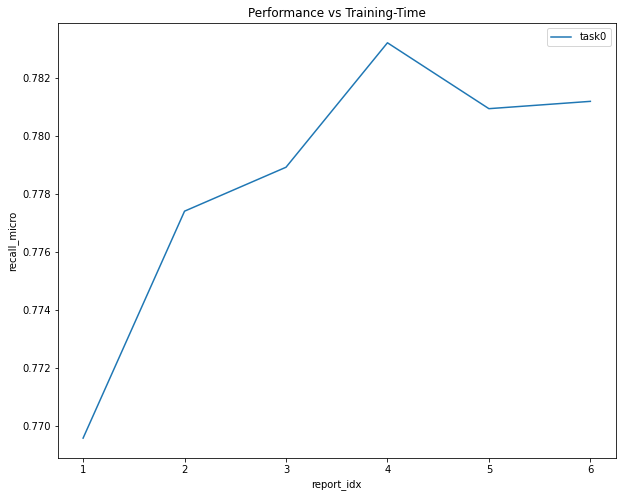

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F5/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6958e-01, log_loss=8.2144e-01, recall_micro=7.6958e-01, time spent=10.931s, total time spent=1.35min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7438e-01, log_loss=7.4107e-01, recall_micro=7.7438e-01, time spent=10.318s, total time spent=2.64min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7539e-01, log_loss=7.4369e-01, recall_micro=7.7539e-01, time spent=10.074s, total time spent=3.90min. Find new best=True, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7893e-01, log_loss=7.4366e-01, recall_micro=7.7893e-01, time spent=10.479s, total time spent=5.18min. Find new best=True, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.8044e-01, log_loss=7.3085e-01, recall_micro=7.8044e-01, time spent=10.627s, total time spent=6.47min. Find new best=True, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.7665e-01, log_loss=7.2398e-01, recall_m

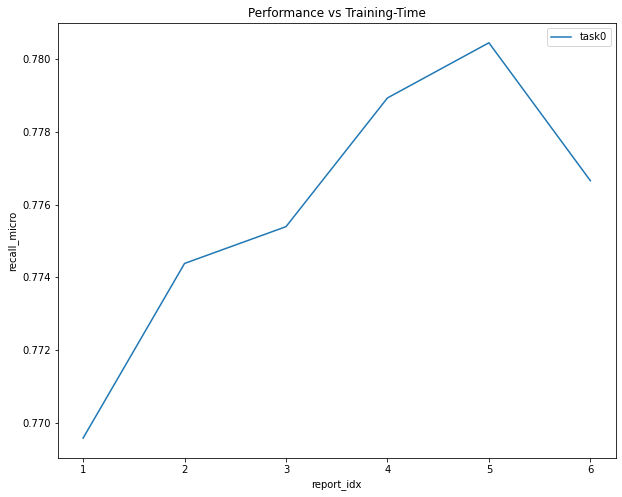

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F6/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6958e-01, log_loss=8.1724e-01, recall_micro=7.6958e-01, time spent=10.352s, total time spent=1.32min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7817e-01, log_loss=7.4477e-01, recall_micro=7.7817e-01, time spent=10.382s, total time spent=2.64min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7463e-01, log_loss=7.4628e-01, recall_micro=7.7463e-01, time spent=10.421s, total time spent=3.89min. Find new best=False, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7564e-01, log_loss=7.3957e-01, recall_micro=7.7564e-01, time spent=10.710s, total time spent=5.18min. Find new best=False, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.7817e-01, log_loss=7.2650e-01, recall_micro=7.7817e-01, time spent=10.403s, total time spent=6.53min. Find new best=True, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.7716e-01, log_loss=7.1572e-01, recall

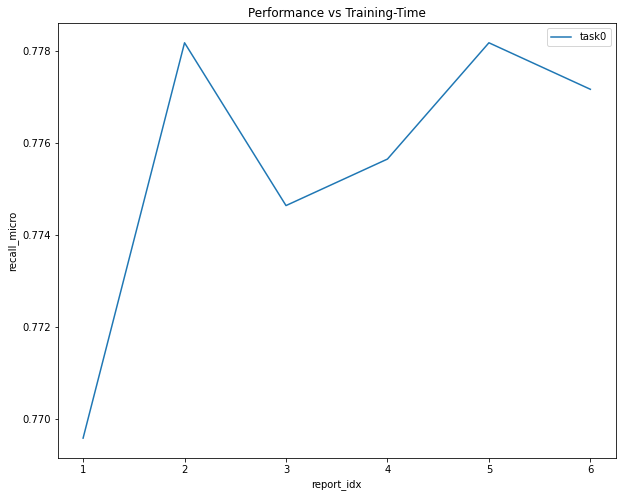

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F7/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6958e-01, log_loss=8.0732e-01, recall_micro=7.6958e-01, time spent=10.778s, total time spent=1.32min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7362e-01, log_loss=7.3757e-01, recall_micro=7.7362e-01, time spent=10.772s, total time spent=2.62min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7640e-01, log_loss=7.4181e-01, recall_micro=7.7640e-01, time spent=10.782s, total time spent=3.91min. Find new best=True, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7842e-01, log_loss=7.2256e-01, recall_micro=7.7842e-01, time spent=10.260s, total time spent=5.19min. Find new best=True, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.7691e-01, log_loss=7.3671e-01, recall_micro=7.7691e-01, time spent=9.920s, total time spent=6.38min. Find new best=False, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.7943e-01, log_loss=7.1828e-01, recall_m

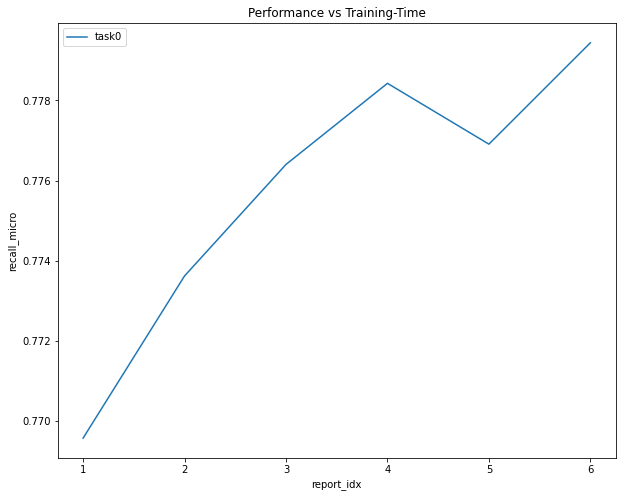

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F8/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6958e-01, log_loss=8.0028e-01, recall_micro=7.6958e-01, time spent=9.801s, total time spent=1.33min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7489e-01, log_loss=7.4516e-01, recall_micro=7.7489e-01, time spent=9.481s, total time spent=2.64min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7792e-01, log_loss=7.2540e-01, recall_micro=7.7792e-01, time spent=9.482s, total time spent=3.92min. Find new best=True, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7388e-01, log_loss=7.2900e-01, recall_micro=7.7388e-01, time spent=9.607s, total time spent=5.16min. Find new best=False, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.8019e-01, log_loss=7.1938e-01, recall_micro=7.8019e-01, time spent=9.924s, total time spent=6.51min. Find new best=True, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.7615e-01, log_loss=7.2510e-01, recall_micro

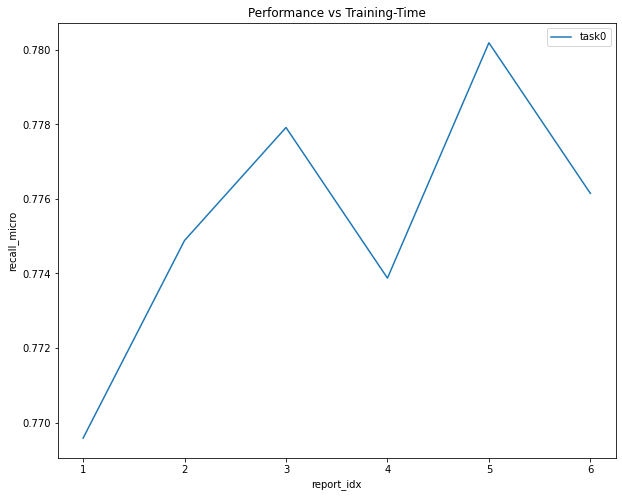

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F9/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6933e-01, log_loss=8.0623e-01, recall_micro=7.6933e-01, time spent=10.709s, total time spent=1.44min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7564e-01, log_loss=7.8591e-01, recall_micro=7.7564e-01, time spent=10.728s, total time spent=2.74min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7615e-01, log_loss=7.4052e-01, recall_micro=7.7615e-01, time spent=9.987s, total time spent=4.01min. Find new best=True, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7388e-01, log_loss=7.3065e-01, recall_micro=7.7388e-01, time spent=9.920s, total time spent=5.23min. Find new best=False, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.7691e-01, log_loss=7.2430e-01, recall_micro=7.7691e-01, time spent=10.045s, total time spent=6.51min. Find new best=True, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.7261e-01, log_loss=7.2222e-01, recall_mi

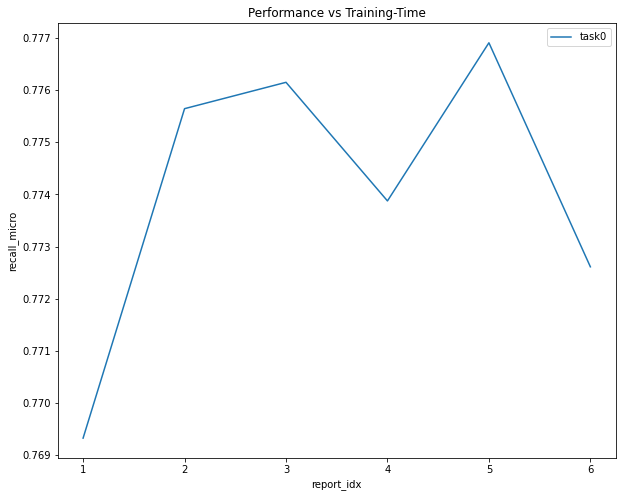

All Logs will be saved to /root/sentiment-analysis/marlette-ds-challenge2/AutogluonModels/ag-20211224_175005/models/TextPredictor_BAG_L1/S1F10/task0/training.log


[Iter 56/2790, Epoch 0] valid accuracy=7.6933e-01, log_loss=8.1665e-01, recall_micro=7.6933e-01, time spent=11.104s, total time spent=1.37min. Find new best=True, Find new top-3=True
[Iter 112/2790, Epoch 0] valid accuracy=7.7792e-01, log_loss=7.3705e-01, recall_micro=7.7792e-01, time spent=11.196s, total time spent=2.72min. Find new best=True, Find new top-3=True
[Iter 168/2790, Epoch 0] valid accuracy=7.7312e-01, log_loss=7.3883e-01, recall_micro=7.7312e-01, time spent=11.204s, total time spent=4.00min. Find new best=False, Find new top-3=True
[Iter 224/2790, Epoch 0] valid accuracy=7.7388e-01, log_loss=7.4435e-01, recall_micro=7.7388e-01, time spent=11.388s, total time spent=5.28min. Find new best=False, Find new top-3=True
[Iter 280/2790, Epoch 1] valid accuracy=7.7716e-01, log_loss=7.1697e-01, recall_micro=7.7716e-01, time spent=11.303s, total time spent=6.59min. Find new best=False, Find new top-3=True
[Iter 336/2790, Epoch 1] valid accuracy=7.7261e-01, log_loss=7.1679e-01, recal

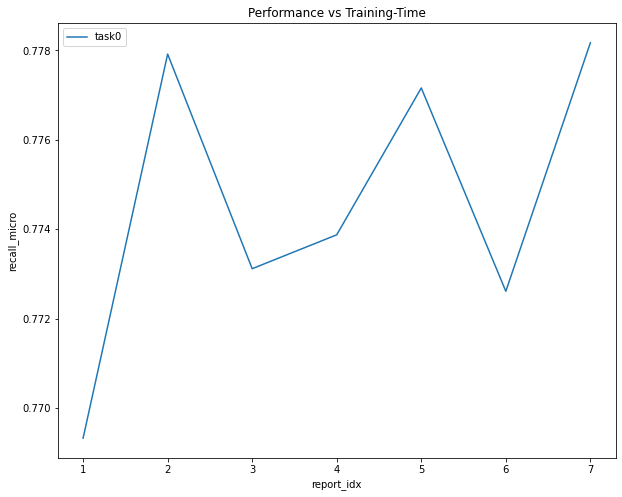

	0.7798	 = Validation score   (recall_micro)
	4838.67s	 = Training   runtime
	117.51s	 = Validation runtime
Fitting model: ImagePredictor_BAG_L1 ... Training model for up to 34.24s of the 3633.73s of remaining time.
	No valid features to train ImagePredictor_BAG_L1... Skipping this model.
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 719.36s of the 3633.41s of remaining time.
	0.7802	 = Validation score   (recall_micro)
	12.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting 6 L2 models ...
Fitting model: LightGBM_BAG_L2 ... Training model for up to 3620.72s of the 3620.6s of remaining time.
	0.778	 = Validation score   (recall_micro)
	249.56s	 = Training   runtime
	2.46s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 3366.4s of the 3366.27s of remaining time.
	0.7796	 = Validation score   (recall_micro)
	215.13s	 = Training   runtime
	2.31s	 = Validation runtime
Fitting model: C

[20:11:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

	0.7801	 = Validation score   (recall_micro)
	172.13s	 = Training   runtime
	1.12s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L2 ... Training model for up to 2133.68s of the 2133.56s of remaining time.
	0.7801	 = Validation score   (recall_micro)
	512.45s	 = Training   runtime
	1.99s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 1617.93s of the 1617.81s of remaining time.
	0.7762	 = Validation score   (recall_micro)
	653.51s	 = Training   runtime
	5.79s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 362.07s of the 952.64s of remaining time.
	0.781	 = Validation score   (recall_micro)
	10.85s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 9858.86s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20211224_175005/")


In [25]:
# Train for best quality
best_predictor=TabularPredictor(label=label,eval_metric=eval_metric).fit(
    train_data=df_train,
    hyperparameters=hyperparameters,
    presets='best_quality',
    time_limit=3*3600)

####  As can be seen, the model did not improve much as compared to our first training

## CONCLUSION:

While there is a wide variety of methods and algorithms to achieve similar result such as:

* Hugging face 🤗 BERT/Transformer model architecture (PyTorch / TensorFlow)
* Sentiment Analysis using VADAR
* Word-Dictionary Based Model
* Naive Base and many more

AutoGluon is a stack that made it possible in building applications involving machine learning with image, text, or tabular data sets by harnessing the power of deep learning for building powerful applications including NLP frameworks like BERT/Transformers. Not only does it utilize  more recent advancements but also enables access to multiple models at a go. The flexibility of choosing from multiple pre-trained NLP models is one of the reasons I love this algorithm.


Closing Note: Though the evaluation metric we achieved here is fairly good but further improvements can be made. Trying different optimization parameters and pre-trained model architecture would surely enhance the performance.